In [1]:
# https://github.com/SebastianMantey/Decision-Tree-from-Scratch/tree/master/data

In [2]:
import numpy as np
import pandas as pd

from pprint import pprint

from decision_tree_functions import decision_tree_algorithm, make_predictions, calculate_accuracy
from helper_functions import generate_data, create_plot, train_test_split

In [3]:
def filter_df(df, question):
    feature, comparison_operator, value = question.split()
    
    # continuous feature
    if comparison_operator == "<=":
        df_yes = df[df[feature] <= float(value)]
        df_no =  df[df[feature] >  float(value)]
        
    # categorical feature
    else:
        df_yes = df[df[feature].astype(str) == value]
        df_no  = df[df[feature].astype(str) != value]
    
    return df_yes, df_no

In [4]:
def post_pruning(tree, df_train, df_val):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        leaf = df_train.label.value_counts().index[0]
        errors_leaf = sum(df_val.label != leaf)
        errors_decision_node = sum(df_val.label != make_predictions(df_val, tree))

        if errors_leaf <= errors_decision_node:
            return leaf
        else:
            return tree
        
    # recursive part
    else:
        
    
        return tree

In [5]:
def determine_leaf(df_train, ml_task):
    
    if ml_task == "regression":
        return df_train.label.mean()
    
    # classification
    else:
        return df_train.label.value_counts().index[0]

In [6]:
def determine_errors(df_val, tree, ml_task):
    predictions = make_predictions(df_val, tree)
    actual_values = df_val.label
    
    if ml_task == "regression":
        # mean squared error
        return ((predictions - actual_values) **2).mean()
    else:
        # number of errors
        return sum(predictions != actual_values)

In [7]:
def pruning_result(tree, df_train, df_val, ml_task):
    
    leaf = determine_leaf(df_train, ml_task)
    errors_leaf = determine_errors(df_val, leaf, ml_task)
    errors_decision_node = determine_errors(df_val, tree, ml_task)

    if errors_leaf <= errors_decision_node:
        return leaf
    else:
        return tree

In [8]:
def post_pruning(tree, df_train, df_val, ml_task):
    
    question = list(tree.keys())[0]
    yes_answer, no_answer = tree[question]

    # base case
    if not isinstance(yes_answer, dict) and not isinstance(no_answer, dict):
        return pruning_result(tree, df_train, df_val, ml_task)
        
    # recursive part
    else:
        df_train_yes, df_train_no = filter_df(df_train, question)
        df_val_yes, df_val_no = filter_df(df_val, question)
        
        if isinstance(yes_answer, dict):
            yes_answer = post_pruning(yes_answer, df_train_yes, df_val_yes, ml_task)
            
        if isinstance(no_answer, dict):
            no_answer = post_pruning(no_answer, df_train_no, df_val_no, ml_task)
        
        tree = {question: [yes_answer, no_answer]}
    
        return pruning_result(tree, df_train, df_val, ml_task)

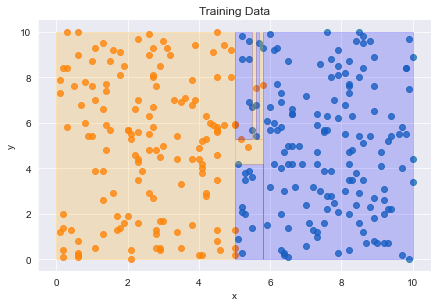

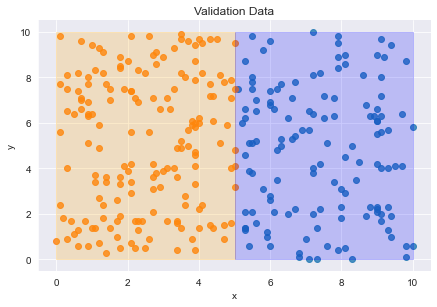

In [9]:
# np.random.seed(0)
df_train = generate_data(n=300, n_random_outliers=5)
tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=10)
create_plot(df_train, tree, title="Training Data")

# np.random.seed(7)
df_val = generate_data(n=300)
tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
create_plot(df_val, tree_pruned, title="Validation Data")

In [10]:
df = pd.read_csv("Titanic.csv")
df["label"] = df.Survived
df = df.drop(["PassengerId", "Survived", "Name", "Ticket", "Cabin"], axis=1)

# handling missing values
median_age = df.Age.median()
mode_embarked = df.Embarked.mode()[0]

df = df.fillna({"Age": median_age, "Embarked": mode_embarked})

# print df
print(df)

     Pclass     Sex   Age  SibSp  Parch     Fare Embarked  label
0         3    male  22.0      1      0   7.2500        S      0
1         1  female  38.0      1      0  71.2833        C      1
2         3  female  26.0      0      0   7.9250        S      1
3         1  female  35.0      1      0  53.1000        S      1
4         3    male  35.0      0      0   8.0500        S      0
..      ...     ...   ...    ...    ...      ...      ...    ...
886       2    male  27.0      0      0  13.0000        S      0
887       1  female  19.0      0      0  30.0000        S      1
888       3  female  28.0      1      2  23.4500        S      0
889       1    male  26.0      0      0  30.0000        C      1
890       3    male  32.0      0      0   7.7500        Q      0

[891 rows x 8 columns]


In [11]:
metrics = {"max_depth": [], "acc_tree": [], "acc_tree_pruned": []}
for n in range(10, 26):
    df_train, df_test = train_test_split(df, test_size=0.15)
    df_train, df_val = train_test_split(df_train, test_size=0.15)

    tree = decision_tree_algorithm(df_train, ml_task="classification", max_depth=n)
    tree_pruned = post_pruning(tree, df_train, df_val, ml_task="classification")
    
    metrics["max_depth"].append(n)
    metrics["acc_tree"].append(calculate_accuracy(df_test, tree))
    metrics["acc_tree_pruned"].append(calculate_accuracy(df_test, tree_pruned))
    
df_metrics = pd.DataFrame(metrics)
df_metrics = df_metrics.set_index("max_depth")

<AxesSubplot:xlabel='max_depth'>

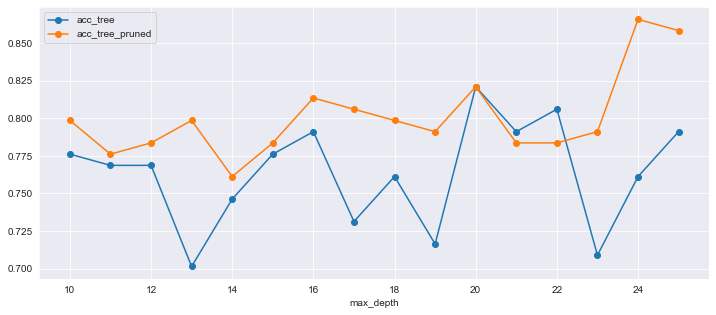

In [12]:
df_metrics.plot(figsize=(12, 5), marker="o")